Created on Nov 20, 2023

Learning based on [Predicting the Survival of Titanic Passengers](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

In [1]:
# importing the libraries
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the data
test_df = pd.read_csv("Titanic/test.csv")
train_df = pd.read_csv("Titanic/train.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We observe that there are some columns having null as information

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. Convert a lot of features into numeric
2. Convert the feature range to the same scale
3. Deal with missing values

In [9]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [42]:
total = train_df.isnull().sum().sort_values(ascending=False) # numbers of missing values
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1,1)).sort_values(ascending=False) # round the percentages and rank by descending order
missing_data = pd.concat([total, percent_2],axis=1, keys=['Total','%']) # concate the two columns together with axis = 1
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


We might drop the Cabin feature since it is largely missing.

In [10]:
train_df.columns.values # the names of the columns

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

We then explore a bit on different features.

Text(0.5, 1.0, 'Male')

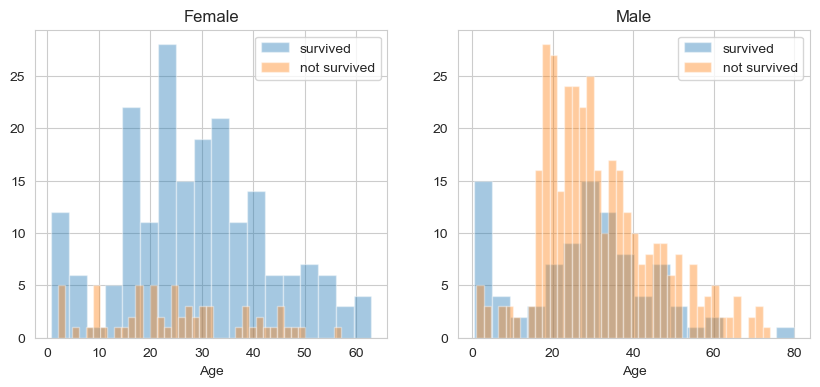

In [11]:
# information on age and sex
survived = 'survived' # label
not_survived = 'not survived' # label

fix,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

women = train_df[train_df['Sex']=='female'] # df for women passengers
men = train_df[train_df['Sex']=='male'] # df for men passengers

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[0],kde=False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[0],kde=False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[1],kde=False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[1],kde=False)
ax.legend()
ax.set_title('Male')

There are certain ages, which have increased odds of survival.

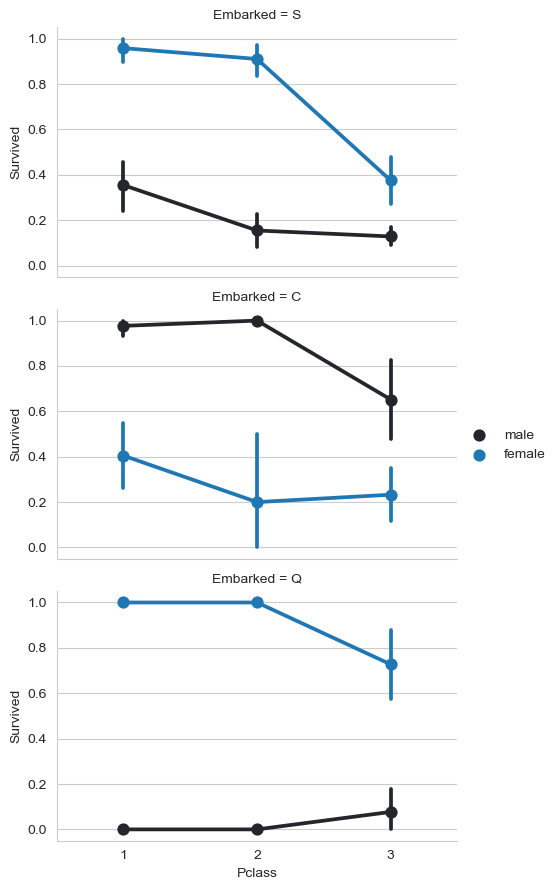

In [12]:
# information on embarked Pclass and sex
FacetGrid = sns.FacetGrid(train_df, row='Embarked', aspect=1.6) # data, row, col, hue
FacetGrid.map(sns.pointplot, 'Pclass','Survived','Sex') # type, x, y, color
FacetGrid.add_legend()

survival rate is correlated with the class and the embarkement place.

We can also see below that the class on the boat is strongly related to the survival rate.

<Axes: xlabel='Pclass', ylabel='Survived'>

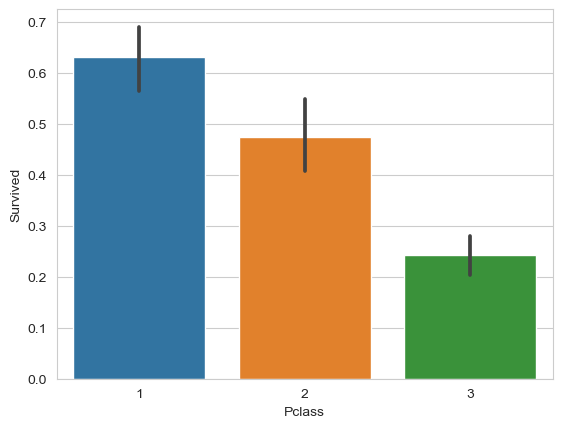

In [13]:
# Pclass
sns.barplot(x='Pclass',y='Survived',data=train_df)

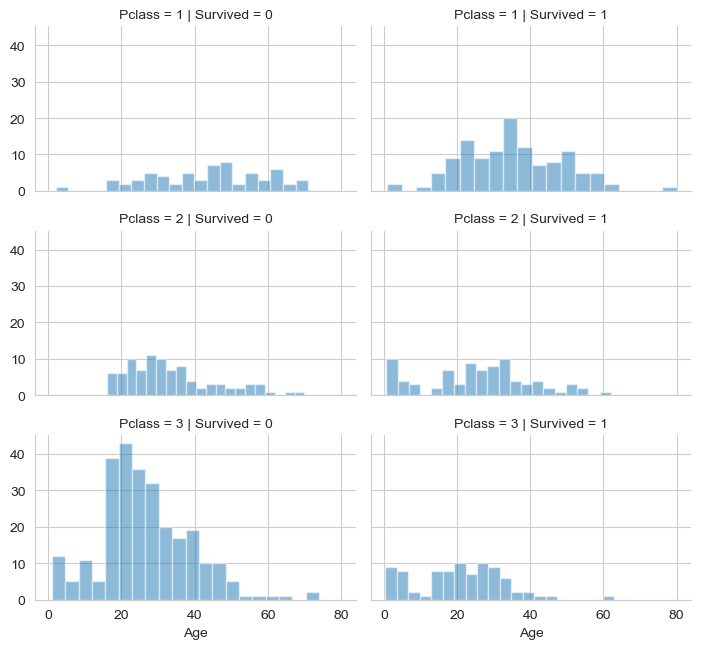

In [14]:
grid = sns.FacetGrid(train_df, col='Survived',row='Pclass',height=2.2,aspect=1.6)
grid.map(plt.hist, 'Age',alpha=0.5, bins=20)
grid.add_legend()

It confirmed that more people survived if they are in first class, but it also reveals that in the third class there are more people who didn't survive.

In [15]:
# sibsp and parch, make a feature to count how many relatives they have on the boat.
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1 # if the person is alone
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

not_alone
1    537
0    354
Name: count, dtype: int64

# Data processing

In [16]:
train_df = train_df.drop(['PassengerId'],axis=1) # it doesn't contribute to the survival rate 
# not drop from the test set since it's demanded for submission

## Missing data

Cabin is serverely missing, but the letter in the Cabin refers to the deck of this person. So we can create a new feature refering to the person's deck.

In [19]:
import re

In [17]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [20]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].map(lambda x:re.compile("([a-zA-Z]+)").search(x).group()) # group returns the entire match, which is the letter
    dataset['Deck'] = dataset['Deck'].map(deck) # map the letters to integer values
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
train_df = train_df.drop(['Cabin'],axis=1)
test_df = test_df.drop(['Cabin'],axis=1)

In [21]:
# fill the missing age with random age, between the standard values
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum() # number of null values
    # give random age
    rand_age = np.random.randint(mean-std, mean+std, size=is_null)
    # fill the nan values
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

In [22]:
# fill the embarked information with the common value
train_df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [23]:
common_value='S'
data = [train_df, test_df]

for dataset in data:
    dataset["Embarked"] = dataset["Embarked"].fillna(common_value)

## converting features

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int32  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int32  
 12  Deck       891 non-null    int32  
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 80.2+ KB


In [25]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,1,0,8
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,0,3
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,0,1,8
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,1,0,3
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,0,1,8


In [26]:
# convert fare into integer
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [28]:
(dataset.Name.str.extract('([A-Za-z]+)\.',expand=False)).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [29]:
# get the titles of the passenger
data = [train_df, test_df]
titles = {"Mr":1, "Miss":2, "Mrs":3, "Master":4,"Rare":5}

for dataset in data:
    # get titles, the words that are followed by dots
    dataset["Title"] = dataset.Name.str.extract('([A-Za-z]+)\.',expand=False)
    # replace rare titles
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # convert into numerical representation
    dataset["Title"] = dataset["Title"].map(titles)
    
    dataset["Title"] = dataset["Title"].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [31]:
# map sex into numeric results
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [32]:
# drop the tickets feature, there are too many unique tickets
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [33]:
train_df["Embarked"].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [34]:
# convert embarked into numeric
ports = {"S":0, "C":1, "Q":2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Creating groups

We class people into different age groups.

In [35]:
data = [train_df, test_df]
# age grouping
for dataset in data:
    dataset["Age"] = dataset["Age"].astype(int) # convert into integers
    dataset.loc[dataset["Age"]<=11, "Age"] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [36]:
pd.qcut(dataset["Fare"],6)

0      (-0.001, 7.0]
1      (-0.001, 7.0]
2        (8.0, 14.0]
3         (7.0, 8.0]
4        (8.0, 14.0]
           ...      
413       (7.0, 8.0]
414    (55.5, 512.0]
415    (-0.001, 7.0]
416       (7.0, 8.0]
417     (14.0, 26.0]
Name: Fare, Length: 418, dtype: category
Categories (6, interval[float64, right]): [(-0.001, 7.0] < (7.0, 8.0] < (8.0, 14.0] < (14.0, 26.0] < (26.0, 55.5] < (55.5, 512.0]]

In [37]:
data = [train_df, test_df]
# fare grouping
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
train_df["Fare"].value_counts()

Fare
0    241
2    223
1    216
3    158
4     44
5      9
Name: count, dtype: int64

## Creating new features

In [38]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [39]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,6,0,0,1,2,0,1,8,1,18,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


# Building Machine Learning Models

Test set doesn't have labels. Therefore, we will use the predictions on the training set to compare the results of different algorithms.

In [40]:
# based on training data we create feature and target dataset
X_train = train_df.drop("Survived", axis = 1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis = 1).copy()

## SGD

In [41]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test) # predict on the test data

sgd.score(X_train, Y_train)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

In [42]:
acc_sgd

72.39

## Random Forest

In [43]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [44]:
acc_random_forest

93.04

## Logistic Regression

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [46]:
acc_log

81.26

## KNN

In [53]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [54]:
acc_knn

84.85

# K-fold validation for Random Forest

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
rf = RandomForestClassifier(n_estimators=100)
# 10-fold validation, therefore cv=10
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring='accuracy')

print("Scores: ", scores)
print("Mean Score: ", scores.mean())
print("Std Score: ", scores.std())

Scores:  [0.75555556 0.82022472 0.74157303 0.85393258 0.86516854 0.86516854
 0.79775281 0.76404494 0.86516854 0.85393258]
Mean Score:  0.8182521847690387
Std Score:  0.047246920094645026


## Feature importance with Random Forest

In [57]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.208
Sex,0.163
Age_Class,0.095
Deck,0.088
Age,0.079
Pclass,0.069
Fare,0.065
Embarked,0.060
relatives,0.057


<Axes: xlabel='feature'>

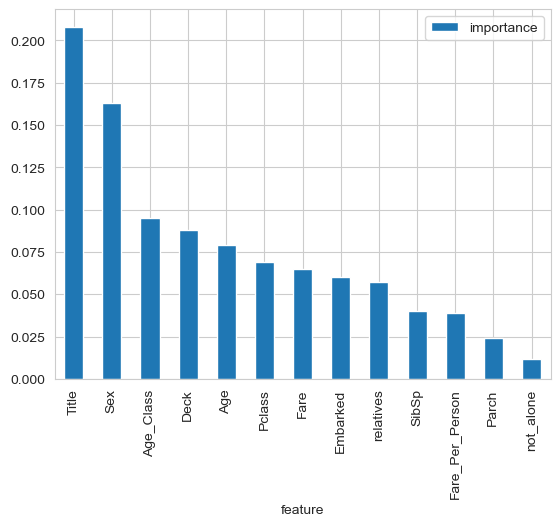

In [58]:
importances.plot.bar()

According to the importance factors, we drop the last two features and retrain our model

In [59]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

In [60]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

93.04 %
